# Create Plots to show the Outcome of the Analysis


### File Saving & Naming Convention

"loc" refers to the country/region/group of stations that is being analysed
"in_var" refers to the pollutant variable that is being analysed

- **df** - the orignial data frame containing weather & pollution data
- **df_prepared** - df.csv augmented by additional variables as calculated in the "Generate Variables" script
- **in_var_all_stats** - statistics regarding the model selection as generated by the "Model Selection" script
- **in_var_chosen_vars** - table with chosen variables as generated by the "Model Selection" script
- **in_var_whisker** - model evaluation statistics as generated by the "Model Evaluation" script
-  **in_var_out** - model evaluation outcome as generated by the "Model Evaluation" script
- **in_var_RMSE** - model evaluation outcome for the transfer model as generated by the "Change_Estimation_Transfer" script
- **in_var_compare_all** - table containing comparison of 2019, 2020, LD model prediction and pre-LD model prediction, as created by the "Change_Estimation_Transfer" script
- **in_var_post_pres** - table containing 2020 values, LD model prediction and pre-LD model prediction for the time period after the lockdown
- **in_var_preds_2019** - table containing 2019 observed values, pre-LD model fitted values and LD- model estimates for the year 2019
  

```
project  
│
└───loc
│   │   df.csv
│   │   df_prepared.csv
│   │   in_var_all_stats.csv
│   │   in_var_chosen_vars.csv
│   │   in_var_whisker.csv
│   │   in_var_out.csv
│   │   in_var_RMSE.csv
│   │   in_var_compare_all.csv
│   │   in_var_compare_lockdown.csv
│   │   in_var_post_preds.csv
│   │   in_var_preds_2019.csv
  
```

In [1]:
# import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LinearGAM, LogisticGAM, s, f,l, GAM, te
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import math
import sklearn.mixture as mix
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from scipy import stats
from functions import GAMf, time_plot_conf, curves, GAMf_train_test
from dateutil.relativedelta import relativedelta
import plotly.graph_objects as go
import plotly.express as px
from dictionaries import starts, ends, che_classes, beijing_classes, wuhan_classes, at_classes, loc_classes, ex_vars_groups, starts2, ends2
import os
import matplotlib.dates as mdates
mapbox_token = "pk.eyJ1IjoiYWJsZSIsImEiOiJja2dta2psNWQwNTZ6MzFxcGN2cGtvYTl5In0.OlKuGKgfiVQwJchrClMQ8A"
px.set_mapbox_access_token(mapbox_token)
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.patches as patches
from matplotlib.dates import DateFormatter

In [2]:
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

In [3]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
# define matplotlib stylesheet
plt.style.use('seaborn')

In [5]:
# specify location and variable of interest
loc = 'che'
in_var ='no2'
IN_VAR = in_var.upper()
classes = loc_classes[loc]

### Table - Model Selection Variable Count

Table of the that shows the number of times a variable group (for variable group classification see dictionaries.py) was chosen by the model selection algorithm.

In [9]:
# initalize data frame
counts = pd.DataFrame(data=None)

# read in chosen variables
chosen_vars = pd.read_csv(loc + '/' + in_var +'_chosen_vars.csv', index_col =0)
#chosen_vars = chosen_vars.drop('amstetten')
#chosen_vars = chosen_vars.drop('ziersdorf')
#chosen_vars = chosen_vars.drop('klosterneuburg-verkehr')
#chosen_vars = chosen_vars.drop('neusiedl')
#chosen_vars = chosen_vars.drop('streithofen')
count = pd.DataFrame(chosen_vars.apply(pd.value_counts).sum(axis=1))
count['group'] = count.index
count = count.replace({'group':ex_vars_groups})
count = count.groupby('group').sum()
count.columns = [loc +'_' + in_var]
counts = counts.join(count, how ='outer')
print(counts)

                 che_no2
group                   
PCA                  6.0
RH                   2.0
T                    2.0
WD_X                 6.0
WD_Y                 3.0
WS                   5.0
day_year             2.0
lagpca_halfyear      1.0
weekday              1.0


### Whisker Plot - Model Evaluation

Creates a whisker plot that shows model performance in cross validation (as specified in "Model Evaluation") depending on the number of months used for training.

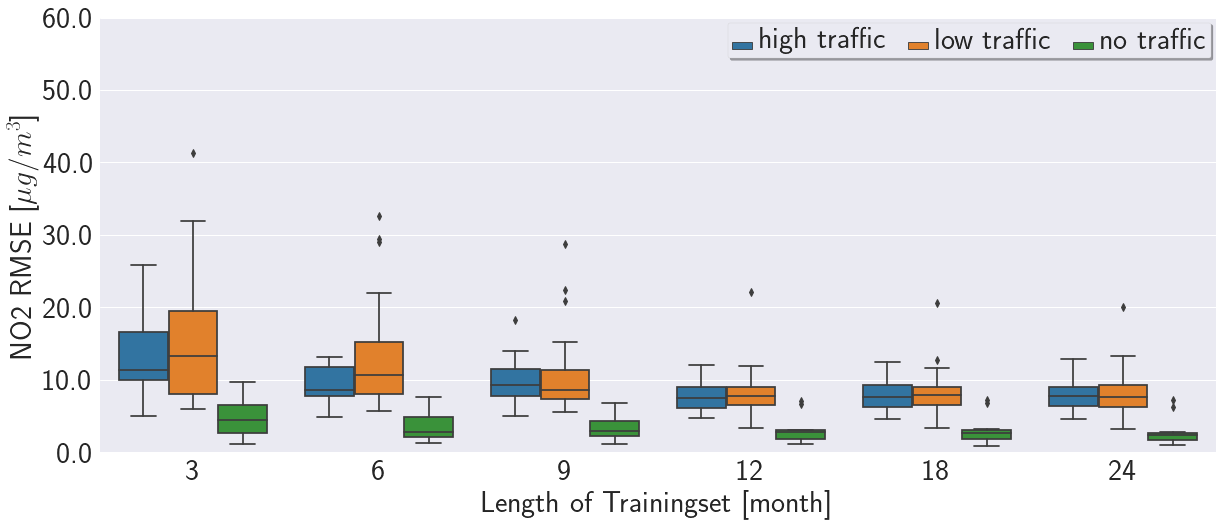

In [12]:
# load dataset respective location & pollutant
cross_validation = pd.read_csv( loc +'/'+ in_var +'_whisker.csv', index_col =0)
cross_validation = cross_validation[cross_validation['city']!='tiantan']
cross_validation = cross_validation[cross_validation['city']!='yufa']
cross_validation = cross_validation[cross_validation['city']!='fangshan']
cross_validation = cross_validation[cross_validation['city']!='liulihe']
cross_validation = cross_validation[cross_validation['city']!='miyunshuiku']
cross_validation = cross_validation[cross_validation['city']!='neusiedl']
cross_validation = cross_validation[cross_validation['train_len']<32]
# set legend label to classes
classes = loc_classes[loc]
legend_label =np.unique(np.array(list(classes.values())))

plt.figure(figsize=(20, 8))
ax = sns.boxplot(x="train_len", y="test_RMSE", hue="class",
                 data=cross_validation, palette="tab10")

ax.set_xlabel('Length of Trainingset [month]', fontsize =30)
ax.set_ylabel(IN_VAR + ' RMSE [$\mu g / m^3$]', fontsize =30)
ax.legend(loc='upper right', shadow = True, frameon = True,ncol=3)


plt.rc('font', size=BIGGER_SIZE)  
plt.rc('axes', labelsize=BIGGER_SIZE) 
plt.rc('legend', fontsize=BIGGER_SIZE)  

n = 0
for i in legend_label:
    ax.legend_.texts[n].set_text(i)
    n += 1

plt.setp(ax.get_legend().get_texts(),fontsize ='30')
plt.setp(ax.get_legend().get_title(),fontsize ='30')
ax.set_ylim(0,60)

ax.set_yticklabels(ax.get_yticks(), size = 30)
ax.set_xticklabels(ax.get_xticks(), size = 30)

plt.xticks([0,1, 2, 3, 4, 5], [3, 6, 9, 12, 18, 24])
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)

#plt.savefig('C:/Users/hicom/Documents/GitHub/corona-pollution/Final/open/'+loc+'/new/whisker_plot.pdf', bbox_inches='tight')

In [13]:
cross_validation.groupby('train_len').mean()

,train_RMSE,test_RMSE
train_len,,
3.0,4.681383,12.511637
6.0,5.175626,10.420280
9.0,5.701807,8.805002
12.0,5.937737,7.142721
18.0,5.995864,7.224588
24.0,6.095406,7.070645


### Weather Comparison Boxplot

Creates a Boxplot that shows the distribution of certain relevant weather variables during the lockdown period and the same time period in 2019.

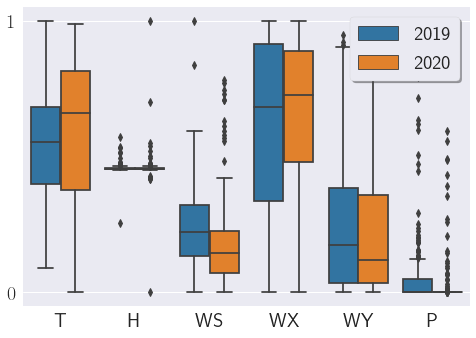

In [58]:
from matplotlib.ticker import MaxNLocator

df = pd.read_csv(loc +'/df2.csv', index_col =0)
df.index = pd.to_datetime(df.index)

start = datetime.strptime(starts[loc], '%m/%d/%Y')
end = datetime.strptime(ends[loc], '%m/%d/%Y')

df_2019 = df[df.index<(end- relativedelta(years=1))]
df_2019 = df_2019[df_2019.index>(start - relativedelta(years=1))]

df_2020 =df[df.index<end]
df_2020 = df_2020[df_2020.index>start]

df_19_20 = df_2019.append(df_2020)

weather_vars = ['t', 'h', 'ws', 'wx', 'wy','p']
org_vars = []
for var_ in weather_vars:
    if var_ in df.columns:
        org_vars.append(var_)

df_norm =df_19_20[org_vars]
df_norm = (df_norm-df_norm.min())/(df_norm.max()-df_norm.min())
df_norm['year'] = df_19_20['year']

df_plot = pd.melt(df_norm, id_vars=['year'], value_vars = org_vars)
ax = sns.boxplot(x = 'variable', y = 'value', hue ='year', data=df_plot, palette="tab10")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.setp(ax.get_legend().get_texts(),fontsize ='30')
plt.setp(ax.get_legend().get_title(),fontsize ='40')

#ax.set_yticklabels(ax.get_yticks(), size = 40)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.yticks(size = 20)
plt.xticks(np.arange(6), ('T', 'H', 'WS', 'WX', 'WY','P'), size = 20)
#ax.set_xticklabels(ax.get_xticks(), labels = [])
ax.legend(loc='upper right', shadow = True, frameon = True)


ax.set_xlabel('')
ax.set_ylabel('')

plt.savefig(loc+'/weather_comparison.pdf', bbox_inches='tight')


## Compare true value of 2019 & 2020 to pre-lockdown model prediction & lockdown model prediction

In [57]:
from dateutil.relativedelta import relativedelta
@interact 
def plot_lockdow(class_ = np.append(np.unique(np.array(list(classes.values()))), 'all')):
    
    @interact
    def plot_lockdown(time_frame = ['lockdown1', 'post_lockdown1', 'lockdown2']):

        df_compare_all = pd.read_csv(loc+'/no2_compare_all.csv', index_col =0)
        df_compare_lockdown1 = pd.read_csv(loc+'/no2_compare_lockdown.csv', index_col =0)
        df_compare_lockdown1['time'] = df_compare_lockdown1.index
        df_compare_all['time'] = df_compare_all.index
        
        # filter for class
        if class_ != 'all':
            df_compare_all = df_compare_all[df_compare_all['class'] == class_]
            df_compare_lockdown1 = df_compare_lockdown1[df_compare_lockdown1['class'] == class_]
        df_compare_all =df_compare_all.groupby('time').mean()
        df_compare_lockdown1 =df_compare_lockdown1.groupby('time').mean()
        df_compare_lockdown1['time'] = df_compare_lockdown1.index
        
       

        df_compare_all['time'] = df_compare_all.index
        df_compare_all.index = pd.to_datetime(df_compare_all.index, format = '%Y-%m-%d', errors = 'coerce')
        
        # find baseline value for apple mobility comparison
        if loc == 'che':
            apple_baseline = df_compare_all[df_compare_all.index == datetime.strptime('02/23/2020', '%m/%d/%Y')][in_var]
            print(apple_baseline)
        
        # filter time frame
        if time_frame == 'lockdown1':
            start = starts[loc]
            end = ends[loc]
        if time_frame == 'post_lockdown1':
            start = ends[loc]
            end = '12/22/2020'
        if time_frame == 'lockdown2':
            start = '12/22/2020'
            end = '02/05/2021'

        start = datetime.strptime(start, '%m/%d/%Y')
        end = datetime.strptime(end, '%m/%d/%Y')
        
        df_compare_all = df_compare_all[df_compare_all.index<end]
        df_compare_all = df_compare_all[df_compare_all.index>=start]
        
        
        # calculate average of same time frame in 2019 as benchmark
        df = pd.read_csv('C:/Users/hicom/Documents/GitHub/corona-pollution/Final/open/'+loc+'/new/df2.csv', index_col =0)
        
        df.index = pd.to_datetime(df.index)
        ref_time_start = start-relativedelta(years =1)
        ref_time_end = end -relativedelta(years =1)
        
        df_ref = df[df.index<ref_time_end]
        df_ref = df_ref[df_ref.index<ref_time_start]
        
        df_ref['class'] = df_ref['city']
        
        df_ref = df_ref.replace({"class": loc_classes[loc]})

        if class_ != 'all':
            df_ref = df_ref[df_ref['class'] == class_]
        
        ref = df_ref.no2.mean()

        # plot
        plt.figure(figsize=(20,5))
        ax = plt.gca()
        df_compare_all.plot(kind='line',x='time',y= in_var,ax=ax,  label = 'Observed Values 2020',lw =3,linestyle=':',color="#006ea3")
        df_compare_all.plot(kind='line',x='time',y='pre_lockdown_model',  ax=ax, label = 'Pre-Lockdown Model Prediction',lw =2,color="#513e3e")
        df_compare_all.plot(kind='line',x='time',y='lockdown_model', ax=ax, label = 'Lockdown Model Prediction',lw =2,color="#e3120b")
        #df_compare_lockdown1.plot(kind='line',x='time',y= in_var + '_2019', ax=ax, label = 'Observed Values 2019',lw =1,linestyle='--',color="#f79b5f")
        _=plt.xticks(rotation=45)
       

        plt.rc('xtick', labelsize=20)
        plt.rc('ytick', labelsize=20)
        plt.rc('legend', fontsize=20)
        plt.xlabel('')

        ax.set_ylabel('NO2', fontsize =20)
        ax.legend(loc ='upper right', frameon=True)
        print(ref_time_start)
        print(ref_time_end)
        plt.savefig('C:/Users/hicom/Documents/GitHub/corona-pollution/Final/21_2/'+loc+'/'+class_+'_comparison.pdf', bbox_inches='tight')

        print('Absolute Differences:')
        print('Mean Difference Observed Values 2020 and pre-LD prediction:', round((df_compare_all[in_var] - df_compare_all['pre_lockdown_model']).mean(), 2))
        print('Mean Difference Observed Values 2020 and LD prediction:', round((df_compare_all[in_var] - df_compare_all['lockdown_model']).mean(), 2))

        print('Relative Differences:')
        print('Mean Difference Observed Values 2020 and pre-LD prediction relative to Average Value observed in 2019:', round((df_compare_all[in_var] - df_compare_all['pre_lockdown_model']).mean()/ref, 3),'%')
        print('Mean Difference Observed Values 2020 and LD prediction relative to Average Value observed in 2019:', round((df_compare_all[in_var] - df_compare_all['lockdown_model']).mean()/ref,3), '%')
        print(ref)
        

        print('Percentage Change Apple Baseline:',round((df_compare_all[in_var] - df_compare_all['pre_lockdown_model']).mean()/apple_baseline.iloc[0], 3),'%' )
        plt.savefig(loc+'/'+ in_var + '_' + class_+ '_'+time_frame+'_estimate.pdf', bbox_inches='tight')


interactive(children=(Dropdown(description='class_', options=('high traffic', 'low traffic', 'no traffic', 'al…

## Plot levels of LD Contribution over time

Text(0.5, 0, '')

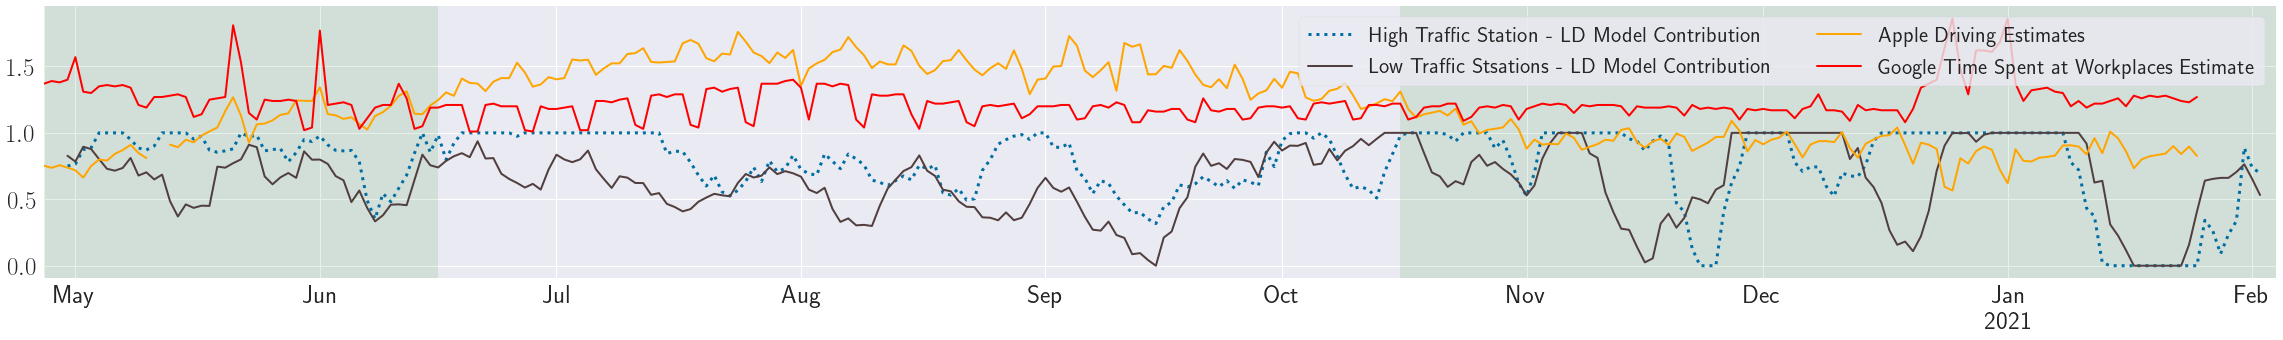

In [21]:
plt.figure(figsize=(40,5))
ax = plt.gca()
df_weeks = pd.DataFrame(columns = ['high traffic', 'low traffic', 'no traffic'])
df_weeks = df_weeks.astype({"high traffic": float, "low traffic": float, "no traffic": float})

for class_ in np.unique(np.array(list(che_classes.values()))):
    
    df_compare_all = pd.read_csv(loc+'/'+ in_var +'_compare_all.csv', index_col =0)
    df_compare_all.index = pd.to_datetime(df_compare_all.index)
    df_compare_all['time'] = df_compare_all.index

    df_compare_all = df_compare_all[df_compare_all['class'] == class_]
    df_compare_all =df_compare_all.groupby('time').mean()
    df_compare_all['time'] = df_compare_all.index
    

    df_compare_all['time'] = df_compare_all.index
    df_compare_all.index = pd.to_datetime(df_compare_all.index, format = '%Y-%m-%d', errors = 'coerce')

    
    start = datetime.strptime('04/26/2020', '%m/%d/%Y')
    end = datetime.strptime('02/05/2021', '%m/%d/%Y')
    df_compare_all = df_compare_all[df_compare_all.index<end]
    df_compare_all = df_compare_all[df_compare_all.index>start]

    df_week = df_compare_all.rolling(6, win_type=None, center = True).mean()
    df_week['x'] = (df_week['no2']-df_week['pre_lockdown_model'])/(df_week['lockdown_model']-df_week['pre_lockdown_model'])
    df_week['time'] = df_week.index
    df_week.loc[df_week['x']<0, 'x'] = 0
    df_week.loc[df_week['x']>1,'x'] = 1 

    df_weeks[class_] = df_week['x']

# get apple mobility data
df_apple = pd.read_csv('apple_mobility_switzerland.csv')
df_apple['date'] = pd.to_datetime(df_apple['date'], format = '%m/%d/%Y')
df_apple3 =df_apple[df_apple['date']>datetime.strptime('04/26/2020', '%m/%d/%Y')]
df_apple3 = df_apple3[df_apple3['date']<datetime.strptime('01/26/2021','%m/%d/%Y')]
df_apple3['driving'] = df_apple3['driving']/100

# get google mobility data
df_weeks['time'] =df_weeks.index
df_google = pd.read_csv('2020_CH_Region_Mobility_Report.csv')    
df_google['date'] = pd.to_datetime(df_google['date'])    
df_google3 =df_google[df_google['date']>datetime.strptime('04/26/2020', '%m/%d/%Y')]
df_google3 = df_google3[df_google3['date']<datetime.strptime('01/26/2021','%m/%d/%Y')]
df_google3['workplaces_percent_change_from_baseline'] =1-df_google3['workplaces_percent_change_from_baseline']/100


# plot
df_weeks.plot(kind='line',x='time',y= np.unique(np.array(list(che_classes.values())))[0],ax=ax,  label = 'High Traffic Station - LD Model Contribution',lw =3,linestyle=':',color="#006ea3")
df_weeks.plot(kind='line',x='time',y=np.unique(np.array(list(che_classes.values())))[1],  ax=ax, label = 'Low Traffic Stsations - LD Model Contribution',lw =2,color="#513e3e")
df_apple3.plot(kind='line',x='date',y='driving',  ax=ax, label = 'Apple Driving Estimates',lw =2,color="orange")
df_google3.plot(kind='line',x='date',y='workplaces_percent_change_from_baseline',  ax=ax, label = 'Google Time Spent at Workplaces Estimate',lw =2,color="red")


plt.axvspan(df_weeks['time'][172], df_weeks['time'][283], facecolor='green', alpha=0.1)
plt.axvspan(df_weeks['time'][0], df_weeks['time'][50], facecolor='green', alpha=0.1)


ax.legend(loc='best', ncol=2, fontsize =22, frameon=True)


plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
plt.rc('font', size=BIGGER_SIZE) 
plt.rc('axes', labelsize=BIGGER_SIZE) 

plt.xlabel('')

## Google and Apple Mobility Trends

Sources:
https://www.google.com/covid19/mobility/
https://covid19.apple.com/mobility

In [23]:
df_google = pd.read_csv('2020_CH_Region_Mobility_Report.csv')

In [24]:
df_google['date'] = pd.to_datetime(df_google['date'])

# lockdown 1
df_google1 =df_google[df_google['date']>datetime.strptime('03/16/2020', '%m/%d/%Y')]
df_google1 = df_google1[df_google1['date']<datetime.strptime('04/26/2020','%m/%d/%Y')]
print('LD1')
print(df_google1.mean())           

# between
df_google2 =df_google[df_google['date']<datetime.strptime('12/22/2020', '%m/%d/%Y')]
df_google1 = df_google2[df_google2['date']>datetime.strptime('04/26/2020','%m/%d/%Y')]
print('Between')
print(df_google2.mean())           

# between
df_google3 =df_google[df_google['date']>datetime.strptime('12/22/2020', '%m/%d/%Y')]
#df_google1 = df_google2[df_google2['date']>datetime.strptime('04/26/2020','%m/%d/%Y')]
print('LD2')
print(df_google3.mean())    

LD1
sub_region_1                                             NaN
sub_region_2                                             NaN
metro_area                                               NaN
iso_3166_2_code                                          NaN
census_fips_code                                         NaN
retail_and_recreation_percent_change_from_baseline   -73.875
grocery_and_pharmacy_percent_change_from_baseline    -15.250
parks_percent_change_from_baseline                    15.525
transit_stations_percent_change_from_baseline        -52.725
workplaces_percent_change_from_baseline              -46.425
residential_percent_change_from_baseline              20.150
dtype: float64
Between
sub_region_1                                                NaN
sub_region_2                                                NaN
metro_area                                                  NaN
iso_3166_2_code                                             NaN
census_fips_code                              

In [25]:
df_apple = pd.read_csv('apple_mobility_switzerland.csv')

In [29]:
df_apple['date'] = pd.to_datetime(df_apple['date'], format = '%m/%d/%Y')

# lockdown 1
df_apple1 =df_apple[df_apple['date']>datetime.strptime('03/16/2020', '%m/%d/%Y')]
df_apple1 = df_apple1[df_apple1['date']<datetime.strptime('04/26/2020','%m/%d/%Y')]
print('LD1')
print(df_apple1.mean())           

# between
df_apple2 =df_apple[df_apple['date']<datetime.strptime('12/22/2020', '%m/%d/%Y')]
df_apple1 = df_apple2[df_apple2['date']>datetime.strptime('04/26/2020','%m/%d/%Y')]
print('Between')
print(df_apple2.mean())           

# between
df_apple3 =df_apple[df_apple['date']>datetime.strptime('12/22/2020', '%m/%d/%Y')]
#df_apple1 = df_apple2[df_apple2['date']>datetime.strptime('04/26/2020','%m/%d/%Y')]
print('LD2')
print(df_apple3.mean())    


#df_apple3.plot( y ='driving')
print(df_apple3)

LD1
driving    59.61550
transit    29.25400
walking    58.52175
dtype: float64
Between
driving    113.303509
transit     78.841140
walking    106.298333
dtype: float64
LD2
driving    84.427556
transit    63.140444
walking    79.731556
dtype: float64
          date  driving  transit  walking
345 2020-12-23    87.86    57.44    97.73
346 2020-12-24    59.38    38.83    57.32
347 2020-12-25    56.59    37.86    40.84
348 2020-12-26    80.84    49.99    68.24
349 2020-12-27    76.89    52.38    61.16
350 2020-12-28    86.26    61.37    81.12
351 2020-12-29    89.74    62.32    84.71
352 2020-12-30    87.23    58.16    83.95
353 2020-12-31    72.46    51.74    79.04
354 2021-01-01    62.02    45.54    50.52
355 2021-01-02    87.64    55.97    69.53
356 2021-01-03    78.89    62.38    64.15
357 2021-01-04    78.46    67.80    76.24
358 2021-01-05    81.28    64.70    80.82
359 2021-01-06    81.91    65.50    81.36
360 2021-01-07    82.88    65.33    82.46
361 2021-01-08    90.48    65.14    

## Spatial Plots of Change in Pollutions

Produces a plot that shows the change in pollutant concentration for every station on a map.

In [44]:
loc = 'che'
in_var ='no2'
IN_VAR = in_var.upper()
classes = loc_classes[loc]

In [43]:
df_locations = pd.read_csv(loc + '/df_locations.csv', index_col=0)

df = pd.read_csv(loc + '/' +'df2.csv', index_col =0)
df.index = pd.to_datetime(df.index)

df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset = [in_var])
df= df[df[in_var]!= 0]
df = df.drop(df[df[in_var]<0].index)

df_compare_all = pd.read_csv(loc+'/'+in_var+'_compare_lockdown.csv', index_col =0)
df_compare_all['diff'] = df_compare_all[in_var+'_2020']-df_compare_all['pre_lockdown_model']

df_compare_all.index = pd.to_datetime(df_compare_all.index, format = '%m/%d', errors = 'coerce')
print(df_compare_all)

df = pd.read_csv(loc+'/df2.csv', index_col =0)
df.index = pd.to_datetime(df.index)


cities = list(df_locations.index)
df_means = pd.DataFrame(index =cities, columns =['prev_mean'])
for city in cities:
    df_city = df[df['city']==city]
    ref_time_start = datetime.strptime(starts[loc], '%m/%d/%Y')-relativedelta(years =1)
    ref_time_end = datetime.strptime(starts[loc], '%m/%d/%Y') -relativedelta(years =1)

    df_ref = df_city[df_city.index<ref_time_end]
    df_ref = df_ref[df_ref.index<ref_time_start]
        
        
    ref = df_ref.no2.mean()
    print(ref)
   

    df_means.loc[city, 'prev_mean'] = ref


df_locations = df_locations.join(df_means['prev_mean'], on='city')

df_locations = df_locations.join(df[df.index < datetime.strptime(starts[loc], '%m/%d/%Y')].groupby('city')[in_var].mean(), on='city', rsuffix='_r')
df_locations = df_locations.join(df_compare_all.groupby('city')['diff'].mean(), on ='city')

df_locations['percentage_change_2019'] =  df_locations['diff']/df_locations['prev_mean']

df_locations['city'] = df_locations.index


df_locations[in_var] = pd.to_numeric(df_locations[in_var])
df = df.dropna(subset = [in_var])

fig = px.scatter_mapbox(df_locations, lat="lat", lon="lon", hover_name="city", color = pd.to_numeric(df_locations['percentage_change_2019']),  color_continuous_scale='Bluered_r', zoom=8, height=600, opacity =0.8,
                        size = in_var,labels ={'color': 'Estimated Change'})

             no2_2020   city   no2_2019  pre_lockdown_model      dummy  \
time                                                                     
1900-01-23  19.000000  1325A        NaN           24.508361  22.774756   
1900-01-24  13.375000  1325A  58.291667           20.589936  19.119225   
1900-01-25  12.291667  1325A  65.391304           15.775285  14.974290   
1900-01-26   9.791667  1325A  46.666667           16.995589  16.688063   
1900-01-27  11.041667  1325A  53.875000           12.266331  12.266331   
...               ...    ...        ...                 ...        ...   
1900-04-03  14.333333  1334A  17.130435           20.771982  19.103730   
1900-04-04  13.125000  1334A  15.208333           17.062747  15.601709   
1900-04-05  29.850000  1334A   9.291667           20.354800  19.000133   
1900-04-06  18.291667  1334A  31.583333           19.413333  19.413333   
1900-04-07  18.083333  1334A  29.333333           21.770321  19.906601   

            lockdown_model  weekday  

In [42]:
df_locations

,lon,lat,prev_mean,no2,diff,percentage_change_2019,city
city,,,,,,,
1325A,114.3672,30.5719,36.1841,35.215371,-14.236654,-0.39345,1325A
1326A,114.2511,30.5514,50.9688,49.378006,-34.668062,-0.680181,1326A
1327A,114.2836,30.6197,48.2469,46.121086,-24.376332,-0.505242,1327A
1328A,114.3006,30.5494,53.4301,51.653512,-29.347128,-0.549262,1328A
1329A,114.4272,30.6103,49.9539,48.352973,-27.345168,-0.547408,1329A
1330A,114.1525,30.4753,50.2896,48.593823,-27.723234,-0.551272,1330A
1331A,114.3008,30.5947,52.9407,50.644902,-29.274837,-0.552974,1331A
1333A,114.2131,30.6414,45.6095,45.443988,-32.000801,-0.701626,1333A
1334A,113.8531,30.2997,29.2832,22.277161,-10.350046,-0.353446,1334A


# Predict 2019

Estimate the percentage change that would occur if the lockdown would have been during the whole year 2019.

In [50]:
def plot_preds(df_pred, in_var, class_):
    plt.figure(figsize=(40,20))
    ax = plt.gca()
    df_pred['time'] = pd.to_datetime(df_pred.index, format = '%Y-%m-%d')
    #print(df_pred)
    df_pred =df_pred.groupby('time').mean()
    #print(df_pred)
    df_pred['time'] = pd.to_datetime(df_pred.index, format = '%Y-%m-%d')
    df_pred.plot(kind='line',x='time',y=in_var,ax=ax,  label = 'True Values',lw =2)
    #df_pred.plot(kind='line',x='time',y='pre_lockdown_model',  ax=ax, label = 'Pre-LD Prediction',lw = 2)
    df_pred.plot(kind='line',x='time',y='lockdown_model', ax=ax, label = 'LD Prediction',lw =2)
    _=plt.xticks(rotation=90)

    ax.get_legend().remove()
    x_axis = ax.axes.get_xaxis()
    x_label = x_axis.get_label()
    #x_label.set_visible(False)
    #ax.set_xlabel('Lockdown Period', fontsize =20)
    ax.set_ylabel(IN_VAR + ' [$\mu g / m^3$]', fontsize =40),    plt.xticks(fontsize = 40)
    plt.yticks(fontsize = 20)
    ax.set_title('')
    #ax.set_ylabel(IN_VAR, fontsize =40)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 30)
    #date_form = DateFormatter("%b")
    #ax.xaxis.set_major_formatter(date_form)
    print('Average for class - absolute decrease:', (df_pred[in_var] - df_pred['lockdown_model']).mean())
    print('Average for class - relative decrease:', ((df_pred[in_var] - df_pred['lockdown_model']).mean())/df_pred[in_var].mean()*100)

In [51]:
preds_2019 = pd.read_csv(loc+ '/' + in_var +'_pred_2019.csv', index_col=0)
df_pred =preds_2019
((df_pred[in_var] - df_pred['lockdown_model']).mean())/df_pred[in_var].mean()*100

31.48547776727953

In [54]:
@interact 
def plot_2019(class_ = np.unique(np.array(list(classes.values())))):
    preds_2019 = pd.read_csv('C:/Users/hicom/Documents/GitHub/corona-pollution/Final/21_2/' +loc+ '/' + in_var +'_pred_2019.csv', index_col=0)
    #print(preds_2019)
    plot_preds(preds_2019[preds_2019['class'] == class_], in_var, class_)
    
    plt.savefig(loc+'/'+'/' + in_var + '_' + class_+ '_2019.pdf', bbox_inches='tight')


interactive(children=(Dropdown(description='class_', options=('high traffic', 'low traffic', 'no traffic'), va…